<a href="https://colab.research.google.com/github/AITrading1995/AITrading1995/blob/main/cointergeation_pairTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git

In [2]:
import pandas as pd
import numpy as np
import requests

import matplotlib.pyplot as plt

from tvDatafeed import TvDatafeed,Interval

In [3]:
def get(symbols,exchange,time,bar):
  def data(symbol):
    tv= TvDatafeed()
    time_map = {
   '1m':Interval.in_1_minute,
   '5m':Interval.in_5_minute,
   '15m':Interval.in_15_minute,
   '30m':Interval.in_30_minute,
   '1h': Interval.in_1_hour,
   '4h':Interval.in_4_hour,
   'D' :Interval.in_daily,
   'W' : Interval.in_weekly}
    return tv.get_hist(symbol=symbol,exchange=exchange,interval=time_map[time],n_bars=bar).drop(columns='symbol')
  datas = map(data,symbols)

  return (pd.concat(datas,keys=symbols,names=['Ticker', 'date']))

In [4]:
symbols=[ 'XAUUSD','EURUSD','AUDNZD','USDJPY','AUDCAD',
'CADJPY','EURGBP','USDTHB']
time = '5m'
exchange='OANDA'
bar=20000

In [ ]:
df = get(symbols, exchange, time, bar)

In [6]:
df_close= returns = df[['close']].reset_index().pivot(index='date', columns='Ticker', values='close').dropna()

In [7]:
log_returns = np.log(df_close/df_close.shift(1))

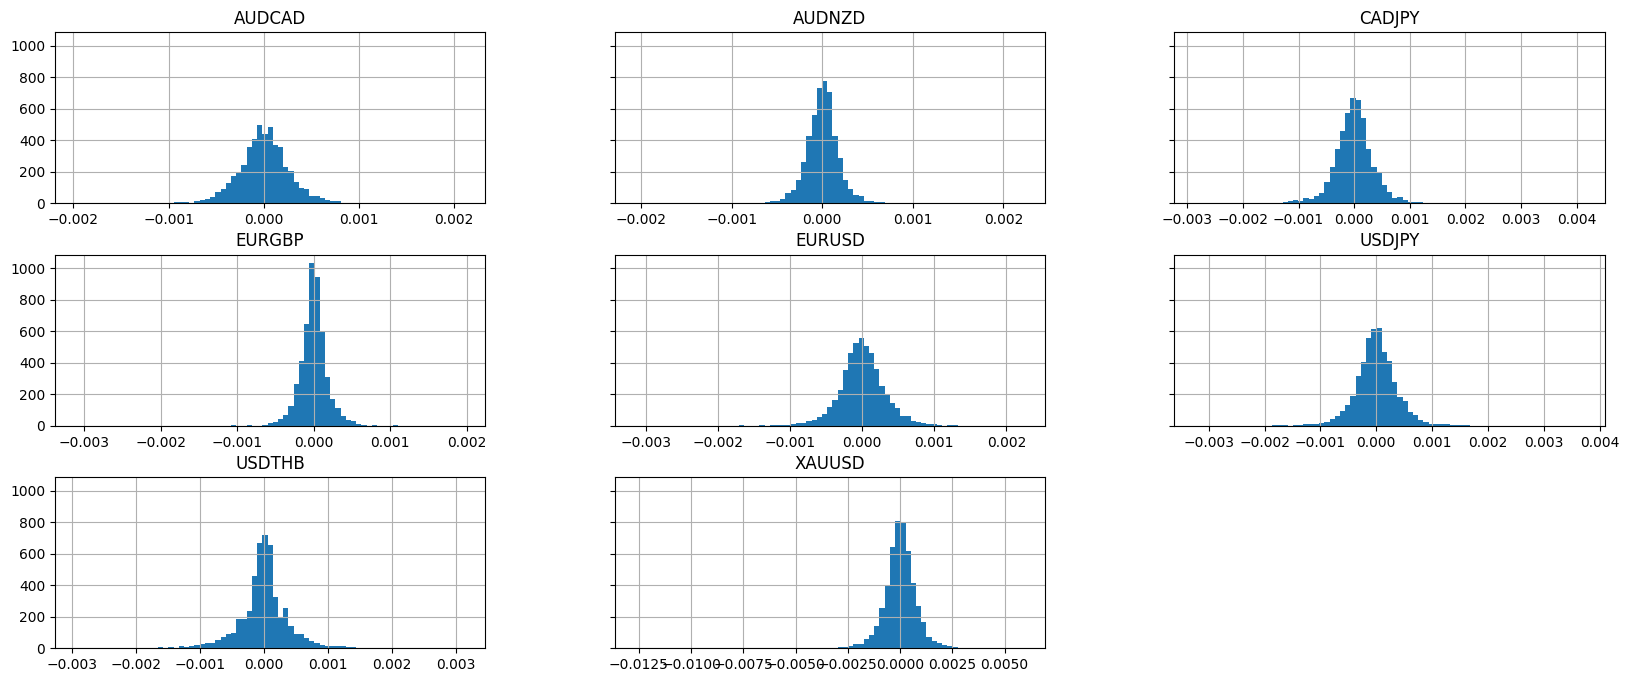

In [8]:
log_returns.dropna().hist(bins=75, figsize=(20, 8), sharey=True)
plt.show()

In [ ]:

import seaborn as sns
sns.set(style="whitegrid")
sns.pairplot(log_returns, height=2.5, diag_kind="kde")
plt.show()

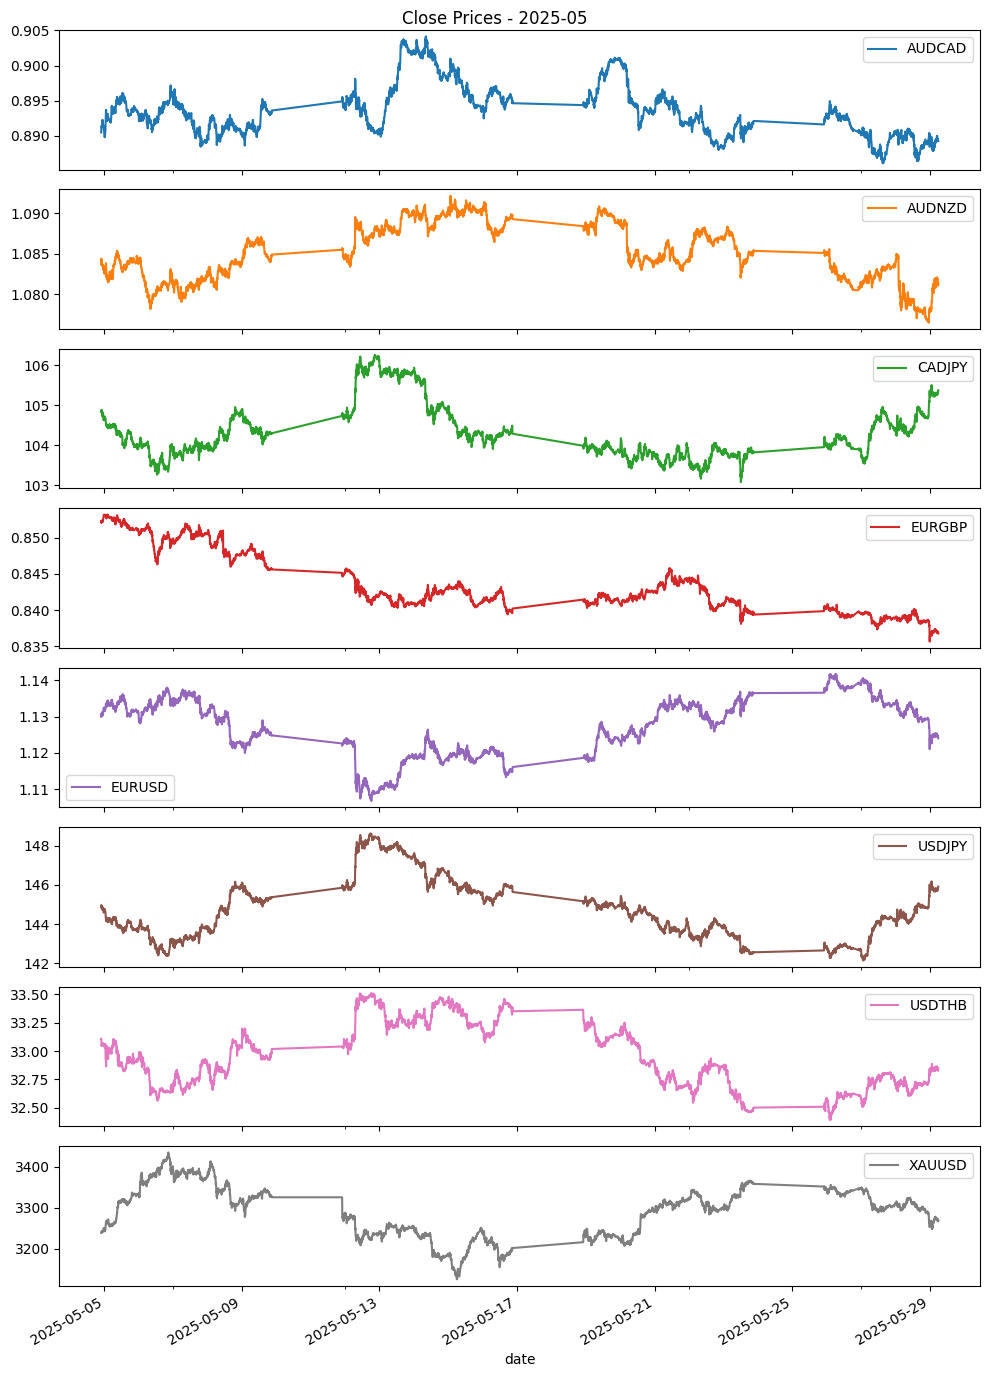

In [10]:
df_close.loc['2025-05':].plot(subplots=True, figsize=(10, 14), layout=(-1, 1), title='Close Prices - 2025-05')
plt.tight_layout()
plt.show()

In [ ]:
df_close

In [ ]:
coin.info()

In [35]:
from statsmodels.tsa.stattools import coint

import itertools

In [36]:
symbols = df_close.columns.tolist()
pairs = list(itertools.combinations(symbols, 2))

In [38]:

results = []
for sym1, sym2 in pairs:
    series1 = df_close[sym1]
    series2 = df_close[sym2]

    score, pvalue, _ = coint(series1, series2)
    results.append({
        'Stock 1': sym1,
        'Stock 2': sym2,
        'P-Value': pvalue,
        'Test Statistic': score
    })

# สร้างตารางผลลัพธ์
coint_df = pd.DataFrame(results)
coint_df = coint_df.sort_values('P-Value')

In [40]:
print(coint_df[coint_df["P-Value"] < 0.05])

   Stock 1 Stock 2   P-Value  Test Statistic
5   AUDCAD  USDTHB  0.027561       -3.558358
23  EURUSD  USDTHB  0.030372       -3.523453
11  AUDNZD  USDTHB  0.031944       -3.505127


In [43]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant


def calculate_spread_beta(series1, series2, window=None):
    """
    คำนวณ Hedge Ratio (Beta), Spread, และ Z-Score สำหรับ Pairs Trading

    Parameters:
    - series1: pd.Series (Asset Y)
    - series2: pd.Series (Asset X)
    - window: int หรือ None → ถ้ากำหนดจะคำนวณ beta แบบ rolling

    Returns:
    - result_df: DataFrame ที่มี ['spread', 'zscore', 'beta']
    """
    df = pd.DataFrame({'Y': series1, 'X': series2}).dropna()

    if window is None:
        # Fixed beta ด้วย OLS regression
        X = add_constant(df['X'])
        model = OLS(df['Y'], X).fit()
        beta = model.params['X']
        df['spread'] = df['Y'] - beta * df['X']
        df['beta'] = beta
    else:
        # Rolling beta
        betas = []
        spreads = []
        for i in range(window, len(df)):
            y = df['Y'].iloc[i - window:i]
            x = df['X'].iloc[i - window:i]
            x = add_constant(x)
            model = OLS(y, x).fit()
            beta = model.params['X']
            spread = df['Y'].iloc[i] - beta * df['X'].iloc[i]
            betas.append(beta)
            spreads.append(spread)
        df = df.iloc[window:].copy()
        df['beta'] = betas
        df['spread'] = spreads

    # คำนวณ Z-Score จาก spread
    df['zscore'] = (df['spread'] - df['spread'].rolling(30).mean()) / df['spread'].rolling(30).std()

    return df

In [44]:
# ตัวอย่าง: ใช้คู่ AUDCAD กับ USDTHB จาก df_wide
result = calculate_spread_beta(df_close['AUDCAD'], df_close['USDTHB'])

# ดูผลลัพธ์เบื้องต้น
print(result.tail())

                           Y       X    spread      beta    zscore
date                                                              
2025-05-29 05:20:00  0.88936  32.836  0.645141  0.007438  0.248001
2025-05-29 05:25:00  0.88927  32.832  0.645080  0.007438  0.041497
2025-05-29 05:30:00  0.88956  32.826  0.645415  0.007438  0.916652
2025-05-29 05:35:00  0.88939  32.842  0.645126  0.007438 -0.039183
2025-05-29 05:40:00  0.88928  32.846  0.644986  0.007438 -0.626902


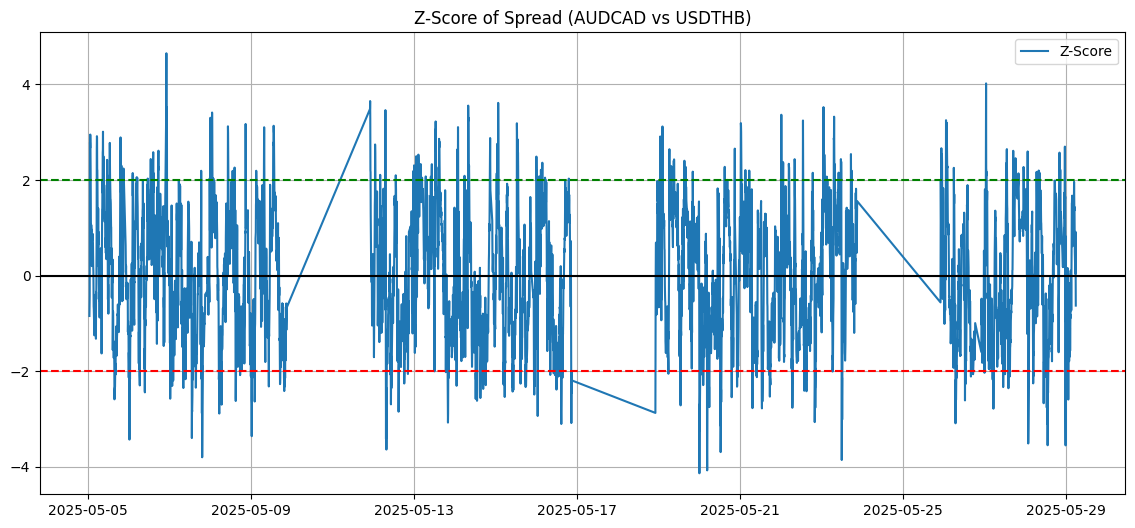

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(result['zscore'], label='Z-Score')
plt.axhline(2.0, color='green', linestyle='--')
plt.axhline(-2.0, color='red', linestyle='--')
plt.axhline(0.0, color='black', linestyle='-')
plt.title('Z-Score of Spread (AUDCAD vs USDTHB)')
plt.legend()
plt.grid(True)
plt.show()

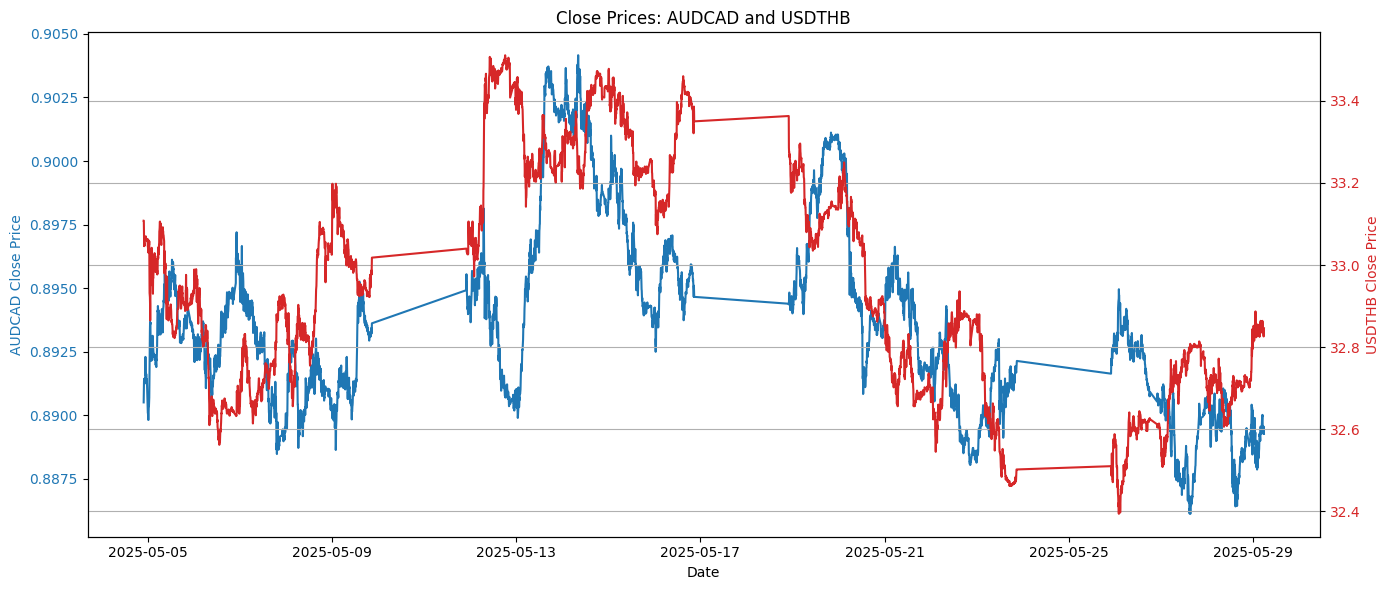

In [48]:



def plot_close_prices(df_wide, symbol1, symbol2):
    fig, ax1 = plt.subplots(figsize=(14,6))

    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{symbol1} Close Price', color='tab:blue')
    ax1.plot(df_wide.index, df_wide[symbol1], color='tab:blue', label=symbol1)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel(f'{symbol2} Close Price', color='tab:red')
    ax2.plot(df_wide.index, df_wide[symbol2], color='tab:red', label=symbol2)
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title(f'Close Prices: {symbol1} and {symbol2}')
    fig.tight_layout()
    plt.grid(True)
    plt.show()

# เรียกใช้
plot_close_prices(df_close, 'AUDCAD', 'USDTHB')